In [67]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pyprogressivex
from time import time
import random

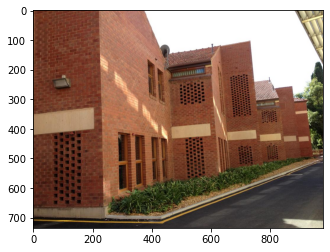

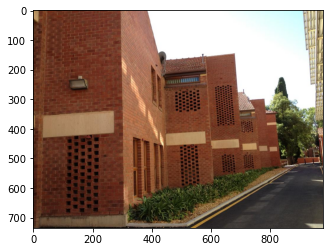

In [68]:
# Load the images
img1 = cv2.cvtColor(cv2.imread('img/unihouse1.png'), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread('img/unihouse2.png'), cv2.COLOR_BGR2RGB)
plt.imshow(img1)
plt.figure()
plt.imshow(img2)

In [69]:
#We will detect ORB features and match them with cross-check test
det = cv2.SIFT_create(8000)    
kps1, descs1 = det.detectAndCompute(img1,None)
kps2, descs2 = det.detectAndCompute(img2,None)

bf = cv2.BFMatcher()

SNN_threshold = 0.9
matches = bf.knnMatch(descs1, descs2, k=2)

# Apply ratio test
snn_ratios = []
tentatives = []
for m, n in matches:
    if m.distance < SNN_threshold * n.distance:
        tentatives.append(m)
        snn_ratios.append(m.distance / n.distance)

sorted_indices = np.argsort(snn_ratios)
tentatives = list(np.array(tentatives)[sorted_indices])

In [70]:
#Now, some visualization from OpenCV tutorial
#https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_feature_homography/py_feature_homography.html
#We will draw correspondences found and the geometric transformation between the images.
from copy import deepcopy
def decolorize(img):
    return  cv2.cvtColor(cv2.cvtColor(img,cv2.COLOR_RGB2GRAY), cv2.COLOR_GRAY2RGB)

def random_color(label):
    if label == 0:
        return (255, 0, 0)
    elif label == 1:
        return (0, 255, 0)
    elif label == 2:
        return (0, 0, 255)
    return (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

def draw_labeling(img1, img2, labeling, correspondences):
    for label in range(max(labeling)):
        mask = labeling == label
        color = random_color(label)

        for i in range(len(labeling)):
            if mask[i]:
                cv2.circle(img1, (round(correspondences[i][0]), round(correspondences[i][1])), 6, color, -1)
                cv2.circle(img2, (round(correspondences[i][2]), round(correspondences[i][3])), 6, color, -1)

    plt.imshow(img1)
    plt.figure()
    plt.imshow(img2)

In [71]:
def verify_pyprogressivex(img1, img2, kps1, kps2, tentatives):    
    correspondences = np.float32([ (kps1[m.queryIdx].pt + kps2[m.trainIdx].pt) for m in tentatives ]).reshape(-1,4)   
    threshold = 1.0
    
    homographies, labeling = pyprogressivex.findHomographies(
        np.ascontiguousarray(correspondences), 
        img1.shape[1], img1.shape[0], 
        img2.shape[1], img2.shape[0],
        threshold = threshold,
        conf = 0.5,
        spatial_coherence_weight = 0.0,
        neighborhood_ball_radius = 200.0,
        maximum_tanimoto_similarity = 0.4,
        max_iters = 1000,
        minimum_point_number = 10,
        maximum_model_number = -1,
        sampler_id = 3,
        do_logging = False)    
    return homographies, labeling

In [72]:
t = time()

homographies, labeling = verify_pyprogressivex(img1, img2, kps1, kps2, tentatives)
model_number = homographies.size / 9

print ('Time = ', time()-t, ' sec')
print ('Models found = {}'.format(model_number))

Time =  0.23112249374389648  sec
Models found = 9.0


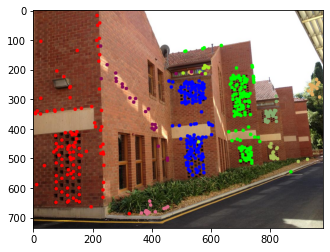

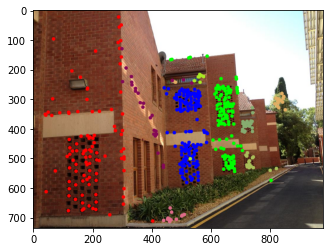

In [73]:
correspondences = np.array([list(kps1[m.queryIdx].pt + kps2[m.trainIdx].pt) for m in tentatives])

draw_labeling(img1, img2, labeling, correspondences)